In [0]:
! git clone https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection.git

Cloning into 'LSTM-Autoencoder-for-Anomaly-Detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (18/18), done.


In [0]:
import zipfile
with zipfile.ZipFile("LSTM-Autoencoder-for-Anomaly-Detection/Sensor Data/Bearing_Sensor_Data_pt1.zip", 'r') as zip_ref:
    zip_ref.extractall("./sensorData")

In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
import seaborn as sns
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
dataDir="sensorData"
mergedData=pd.DataFrame()

for filename in os.listdir(dataDir):
  if filename == "__MACOSX":
    continue
  dataset=pd.read_csv(os.path.join(dataDir,filename),sep="\t")
  dataset_abs_mean=np.array([dataset.abs().mean()])
  dataset_abs_mean=pd.DataFrame(dataset_abs_mean)
  dataset_abs_mean.index=[filename]
  mergedData=mergedData.append(dataset_abs_mean)
mergedData.columns=["bearing1","bearing2","bearing3","bearing4"]

In [0]:
def splitSeq(dataset,l=10,offset=5):
  if l > dataset.shape[0]:
    l=dataset.shape[0]
  final=list()
  for i in range(0,dataset.shape[0],offset):
    if i+l > dataset.shape[0]:
      break
    seq=list(dataset[i:i+l])
    final.append(seq)
  return np.array(final)

In [0]:
train=mergedData[:300]
test=mergedData[300:]

In [0]:
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [0]:
train_fft=np.fft.fft(train)
test_fft=np.fft.fft(test)

In [0]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(train)
X_test=scaler.transform(test)

In [0]:
X_train.shape

(300, 4)

In [0]:
X_train=splitSeq(X_train)
X_test=splitSeq(X_test)

In [0]:
inputs=keras.layers.Input(shape=X_train.shape[1:])
L1=keras.layers.LSTM(16,activation="relu",return_sequences=True)(inputs)
L2=keras.layers.LSTM(4,activation="relu",return_sequences=False)(L1)
L3=keras.layers.RepeatVector(X_train.shape[1])(L2)
L4=keras.layers.LSTM(4,activation="relu",return_sequences=True)(L3)
L5=keras.layers.LSTM(16,activation="relu",return_sequences=True)(L4)
#output=keras.layers.Dense(4)(L5)
output=keras.layers.TimeDistributed(keras.layers.Dense(4))(L5)
model=keras.models.Model(inputs,output)

In [0]:
model.summary()
model.compile(optimizer="adam",loss="mae")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 4)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 16)            1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 4)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 4)             144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 16)            1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 4)             68    

In [0]:
epochs=100
batch_size=10
history=model.fit(X_train,X_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.05,
                  verbose=1).history

Epoch 1/100
6/6 [==============================] - 1s 109ms/step - loss: 0.3786 - val_loss: 0.3796
Epoch 2/100
6/6 [==============================] - 0s 18ms/step - loss: 0.3679 - val_loss: 0.3689
Epoch 3/100
6/6 [==============================] - 0s 19ms/step - loss: 0.3562 - val_loss: 0.3566
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.3426 - val_loss: 0.3412
Epoch 5/100
6/6 [==============================] - 0s 18ms/step - loss: 0.3254 - val_loss: 0.3209
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.3048 - val_loss: 0.3010
Epoch 7/100
6/6 [==============================] - 0s 18ms/step - loss: 0.2909 - val_loss: 0.2943
Epoch 8/100
6/6 [==============================] - 0s 20ms/step - loss: 0.2826 - val_loss: 0.2836
Epoch 9/100
6/6 [==============================] - 0s 19ms/step - loss: 0.2713 - val_loss: 0.2756
Epoch 10/100
6/6 [==============================] - 0s 18ms/step - loss: 0.2617 - val_loss: 0.2660
Epoch 11/100
6/6 [

In [0]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], -1)

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], -1)
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

ValueError: ignored

In [0]:
a=np.array([[[155,  33, 129],
        [161, 218,   6]],

       [[215, 142, 235],
        [143, 249, 164]],

       [[221,  71, 229],
        [ 56,  91, 120]],

       [[236,   4, 177],
        [171, 105,  40]]])
a.shape

(4, 2, 3)

In [0]:
X_test_pred=model.predict(X_test)

In [0]:
X_test_pred=np.array(X_test_pred)
X_test_pred=X_test_pred.reshape(265,4)

In [0]:
X_test=X_test.reshape(265,4)

In [0]:
scored=pd.DataFrame(index=test.index)
scored["loss"]=np.mean(np.abs(X_test-X_test_pred),axis=1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['loss'] > scored['Threshold']
scored.head()

,loss,Threshold,Anomaly
0,0.022525,0.275,False
1,0.049887,0.275,False
2,0.048433,0.275,False
3,0.035259,0.275,False
4,0.101302,0.275,False


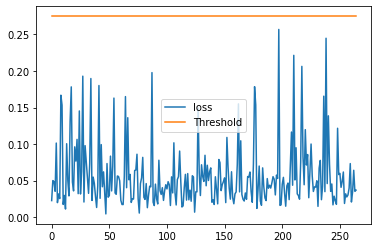

In [0]:
scored.plot(y=["loss","Threshold"])